# Synthetic Experiments

To keep the running time of experiments low, we use smaller values for $L$, $n$, and $r$ than in the paper, and average over fewer trials. However, one can easily increase these parameters in the code.

Below, we import all required packages and define some helper functions to create disconnected random mixtures and for plotting. Note that CA-SVD is able to use any IP-solver integrated in CVXPY to find the best assignment (set `USE_CVXPY=True` in `learn.py`). The default is a simple Python implementation which could be slow for difficult instances.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import *
from functools import *
from learn import *
from data import *
plt.rcParams["text.usetex"] = True


def disconnect(mixture, l, n_parts=2, start=0, partition=None, direction=None):
    n = mixture.n
    if partition is None:
        partition = np.array_split(range(start, start+n), n_parts)
    for p1, p2 in combinations(partition, 2):
        for part1, part2 in [[p1, p2], [p2, p1]]:
            for i, j in product(part1, part2):
                if direction is None or np.sign(i - j) == direction:
                    mixture.Ms[l, i % n, j % n] = 0
    mixture.normalize()

def disconnect_into(mixture, r):
    mixture = mixture.copy()
    if r is None:
        return mixture
    assert (mixture.L <= r <= mixture.n / 2)
    add_n_cc = round(r) - mixture.L
    n_ccs = np.random.rand(mixture.L)
    n_ccs = (add_n_cc * n_ccs / np.sum(n_ccs)).astype(int)
    n_ccs[np.random.choice(mixture.L, add_n_cc - np.sum(n_ccs), replace=False)] += 1
    n_ccs += 1
    for l, n_cc in enumerate(n_ccs):
        xs = np.array(range(mixture.n // 2))
        np.random.shuffle(xs)
        partition = [[x] for x in xs[:n_cc]]
        for x in xs[n_cc:]:
            i = np.random.choice(n_cc)
            partition[i].append(x)
        partition = [[i for x in part for i in [2 * x, 2 * x + 1]] for part in partition]
        disconnect(mixture, l, partition=partition)
    return mixture


def plot(df, x, y, fill=True, **kwargs):
    plt.xlabel(x)
    plt.ylabel(y)
    for learner, learner_df in df.groupby("learner"):
        grp = learner_df.groupby(x)[y]
        med = grp.median()
        plt.plot(med.index, med, label=f"{learner} ({y})", marker="o", **kwargs)
        if fill: plt.fill_between(med.index, grp.quantile(0.25), grp.quantile(0.75), alpha=0.2)

The following contains the three main learners "CA-SVD" (method defined in our paper), "GKV-SVD" (method by Gupta et al.), "EM" (expectation maximization), and derivatives thereof. The variable `n_trials` controls how many times each experiment is repeated.

In [2]:
n_trials = 3

learners = {
    "CA-SVD": svd_learn_new,
    "CA-SVD'": lambda d, n, L: svd_learn_new(d, n, L, sample_dist=0.01),
    "GKV-SVD": svd_learn,
    "EM2": lambda d, n, L: em_learn(d, n, L, max_iter=2),
    "EM5": lambda d, n, L: em_learn(d, n, L, max_iter=5),
    "EM20": lambda d, n, L: em_learn(d, n, L, max_iter=20),
    "EM50": lambda d, n, L: em_learn(d, n, L, max_iter=50),
    "EM100": lambda d, n, L: em_learn(d, n, L, max_iter=100),
    "EM-converge": em_learn,
    "CA-SVD-EM2": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=2),
    "CA-SVD-EM5": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=5),
    "CA-SVD-EM20": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=20),
    "CA-SVD-EM100": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=100),
}

## Learning with exact and empirical 3-trail distribution

For each noise level ($10^6$ samples, $10^8$ samples, exact 3-trail distribution), we define a dataframe that holds the parameters and results of each experiment.

In [3]:
def evaluate(row):
    _, learner, n, L, n_samples, r = row
    mixture = disconnect_into(Mixture.random(n, L), r)
    distribution = Distribution.from_mixture(mixture, 3)
    sample = distribution if n_samples is None else distribution.sample(n_samples)
    learned_mixture = learners[learner](sample, n, L)
    learned_distribution = Distribution.from_mixture(learned_mixture, 3)
    recovery_error = mixture.recovery_error(learned_mixture)
    trail_error = distribution.dist(learned_distribution)
    return {"recovery_error": recovery_error, "trail_error": trail_error}

n = 10
L = 2

def data(n_samples):
    df = pd.DataFrame(product(range(n_trials), ["CA-SVD'", "GKV-SVD", "EM100"], [n], [L], [n_samples], range(L, n//2 + 1)),
                      columns=["n_trial", "learner", "n", "L", "n_samples", "r"])
    res = df.apply(evaluate, axis=1, result_type="expand")
    df[res.columns] = res
    return df

In [5]:
# df1 = data(10**6)
# df2 = data(10**8) spend more than 2 minutes to run this single line, unfeasible in my computer
df1 = data(10**3)
df2 = data(10**5)
df3 = data(None)

/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:314: ComplexWarning: Casting complex values to real discards the imaginary part
  S_[l,i] = Ss[i,l,l]
/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:316: ComplexWarning: Casting complex values to real discards the imaginary part
  Ms_[l,i,j] = Ps[j,l,i] / S_[l,i]
/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:314: ComplexWarning: Casting complex values to real discards the imaginary part
  S_[l,i] = Ss[i,l,l]
/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:316: ComplexWarning: Casting complex values to real discards the imaginary part
  Ms_[l,i,j] = Ps[j,l,i] / S_[l,i]


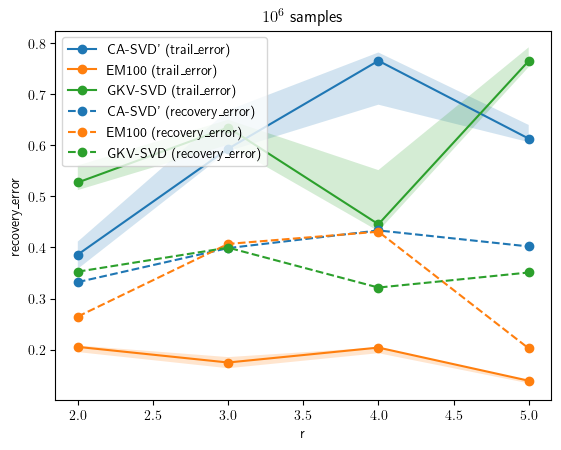

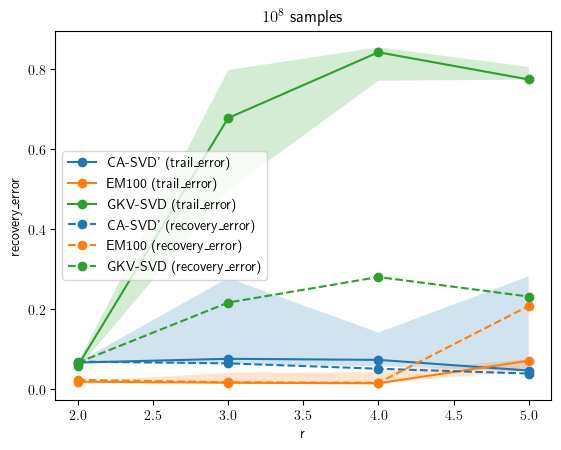

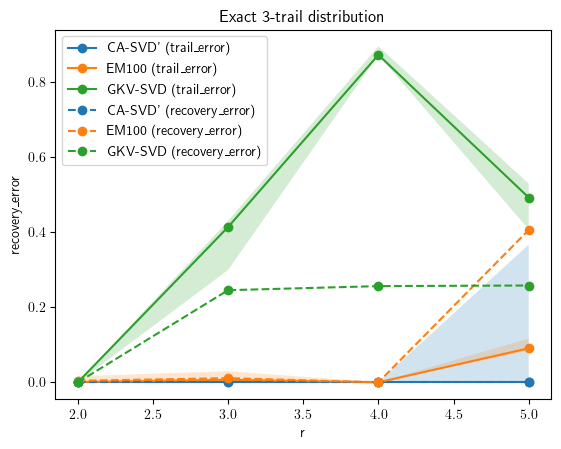

In [6]:
plot(df1, "r", "trail_error")
plt.gca().set_prop_cycle(None)
plot(df1, "r", "recovery_error", fill=False, linestyle="--")
plt.title("$10^6$ samples")
plt.legend()
plt.show()

plot(df2, "r", "trail_error")
plt.gca().set_prop_cycle(None)
plot(df2, "r", "recovery_error", fill=False, linestyle="--")
plt.title("$10^8$ samples")
plt.legend()
plt.show()

plot(df3, "r", "trail_error")
plt.gca().set_prop_cycle(None)
plot(df3,  "r","recovery_error", fill=False, linestyle="--")
plt.title("Exact 3-trail distribution")
plt.legend()
plt.show()

## Combining CA-SVD with EM

We redo the above experiment, but also for the combined method.

In [7]:
df = pd.DataFrame(product(range(n_trials), ["CA-SVD-EM100", "CA-SVD'", "EM100"], [n], [L], [10**6], range(L, n//2 + 1)), 
                  columns=["n_trial", "learner", "n", "L", "n_samples", "r"])
res = df.apply(evaluate, axis=1, result_type="expand")
df[res.columns] = res

Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 62, in combine
    assert(max(groups)+1 == r)
AssertionError

Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 62, in combine
    assert(max(groups)+1 == r)
AssertionError

Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 62, in combine
    assert(max(groups)+1 == r)
AssertionError



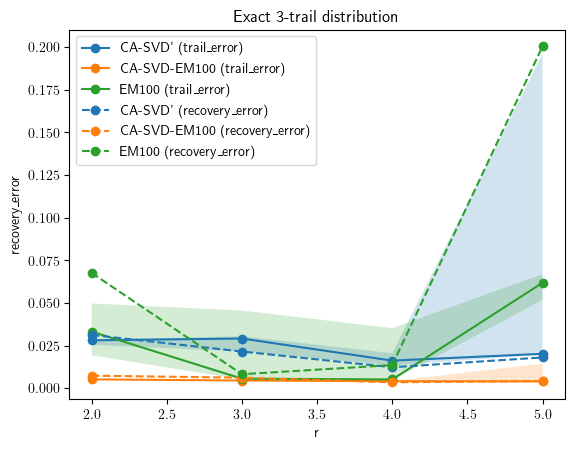

In [8]:
plot(df, "r", "trail_error")
plt.gca().set_prop_cycle(None)
plot(df, "r", "recovery_error", fill=False, linestyle="--")
plt.title("Exact 3-trail distribution")
plt.legend()
plt.show()

## Sample Complexity

We perform a binary search to determine for which number of samples a method obtains trail or recovery error below a certain threshold.

In [9]:
def determine_sample_complexity(measure, threshold, row):
    _, learner, n, L, r = row
    mixture = disconnect_into(Mixture.random(n, L), r)
    distribution = Distribution.from_mixture(mixture, 3)

    fails = 0
    n_samples = 10**6
    exp_avg_n_samples = None
    print(learner, end=" ")
    while fails < 5:
        print(f"{int(n_samples):.2e}", end=" ")
        sample = distribution.sample(int(n_samples))
        learned_mixture = learners[learner](sample, n, L)
        learned_distribution = Distribution.from_mixture(learned_mixture, 3)
        recovery_error = mixture.recovery_error(learned_mixture)
        trail_error = distribution.dist(learned_distribution)
        measures = {"recovery_error": recovery_error, "trail_error": trail_error}
        if measures[measure] < threshold:
            exp_avg_n_samples = n_samples if exp_avg_n_samples is None else 0.5 * exp_avg_n_samples + 0.5 * n_samples
            n_samples /= 3
            print("O", end=" ")
        else:
            fails += 1
            n_samples *= 3
            print("F", end=" ")
    
    print("->", exp_avg_n_samples)
    return exp_avg_n_samples

In [10]:
n = 10
L = 2

df = pd.DataFrame(itertools.product(range(n_trials), ["CA-SVD'", "GKV-SVD", "EM50", "EM100"], [n], [L], range(L, n//2 + 1)), 
                  columns=["n_trial", "learner", "n", "L", "r"])
n_samples_trail_error = df.apply(partial(determine_sample_complexity, "trail_error", 0.05), axis=1)
n_samples_recovery_error = df.apply(partial(determine_sample_complexity, "recovery_error", 0.05), axis=1)
df["n_samples_trail_error"] = n_samples_trail_error
df["n_samples_recovery_error"] = n_samples_recovery_error

CA-SVD' 1.00e+06 O 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 O 3.70e+04 F 1.11e+05 F 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F -> 326388.8888888889
CA-SVD' 1.00e+06 O 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F -> 354166.6666666666
CA-SVD' 1.00e+06 O 3.33e+05 F 1.00e+06 O 3.33e+05 O 1.11e+05 F 3.33e+05 O 1.11e+05 F 3.33e+05 F 1.00e+06 O 3.33e+05 O 1.11e+05 F -> 541666.6666666666
CA-SVD' 1.00e+06 O 3.33e+05 O 1.11e+05 O 3.70e+04 F 1.11e+05 O 3.70e+04 F 1.11e+05 O 3.70e+04 F 1.11e+05 O 3.70e+04 F 1.11e+05 O 3.70e+04 F -> 128472.22222222222
GKV-SVD 1.00e+06 O 3.33e+05 F 1.00e+06 O 3.33e+05 O 1.11e+05 F 3.33e+05 F 1.00e+06 O 3.33e+05 F 1.00e+06 O 3.33e+05 F -> 916666.6666666666
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
EM50 1.00e+06 O 3.33e+05 O 1.11e+05 

/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  dists[k] = np.linalg.norm(rinv1 - rinv2)**2 / (np.linalg.norm(rinv1) * np.linalg.norm(rinv2))
/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:49: RuntimeWarning: invalid value encountered in scalar divide
  dists[k] = np.linalg.norm(rinv1 - rinv2)**2 / (np.linalg.norm(rinv1) * np.linalg.norm(rinv2))


Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 59, in combine
    lnk = linkage(double_dists, method="complete")
  File "/Users/hayashimiyako/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1064, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 59, in combine
    lnk = linkage(double_dists, method="complete")
  File "/Users/hayashimiyako/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1064, in linkage
    rais

/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:314: ComplexWarning: Casting complex values to real discards the imaginary part
  S_[l,i] = Ss[i,l,l]
/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:316: ComplexWarning: Casting complex values to real discards the imaginary part
  Ms_[l,i,j] = Ps[j,l,i] / S_[l,i]


F -> 3500000.0
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
GKV-SVD 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F 8.10e+07 F -> None
EM50 1.00e+06 O 3.33e+05 O 1.11e+05 O 3.70e+04 O 1.23e+04 F 3.70e+04 O 1.23e+04 F 3.70e+04 F 1.11e+05 O 3.70e+04 O 1.23e+04 F 3.70e+04 O 1.23e+04 F -> 57291.666666666664
EM50 1.00e+06 F 3.00e+06 O 1.00e+06 F 3.00e+06 O 1.00e+06 O 3.33e+05 O 1.11e+05 O 3.70e+04 F 1.11e+05 O 3.70e+04 O 1.23e+04 O 4.12e+03 F 1.23e+04 F -> 109182.09876543209
EM50 1.00e+06 F 3.00e+06 O 1.00e+06 O 3.33e+05 O 1.11e+05 O 3.70e+04 O 1.23e+04 O 4.12e+03 F 1.23e+04 O 4.12e+03 F 1.23e+04 F 3.70e+04 F -> 93750.0
EM50 1.00e+06 F 3.00e+06 O 1.00e+06 F 3.00e+06 F 9.00e+06 F 2.70e+07 F -> 3000000
EM100 1.00e+06 O 3.33e+05 O 1.11e+05 O 3.70e+04 O 1.23e+04 F 3.70e+04 O 1.23e+04 F 3.70e+04 O 1.23e+04 O 4.12e+03 F 1.23e+04 F 3.70e+04 O 1.23e+04 F -> 41859.567901234564
EM100 1.00e+06 O 3.33e+05 O 1.1

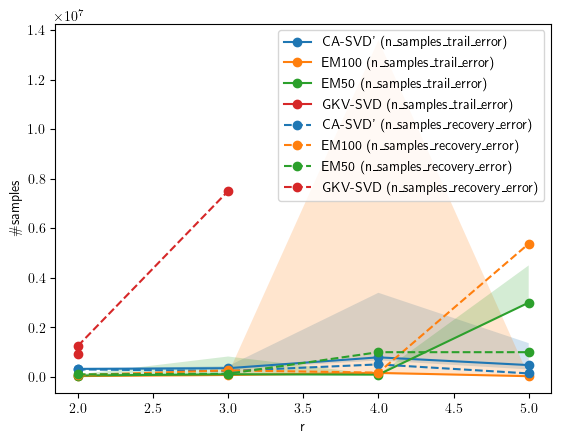

In [11]:
fig, ax = plt.subplots()
plot(df, "r", "n_samples_trail_error")
plt.gca().set_prop_cycle(None)
plot(df, "r", "n_samples_recovery_error", fill=False, linestyle="--")
plt.ylabel("\#samples")
plt.legend()
plt.show()

## Scalability

We simply measure the time for each method

In [12]:
def measure_time(row):
    _, learner, n, L, r = row
    mixture = disconnect_into(Mixture.random(n, L), r)
    distribution = Distribution.from_mixture(mixture, 3)
    stats = {}
    t = time.time()
    learned_mixture = learners[learner](distribution, n, L, stats=stats)
    learning_time = time.time() - t
    n_iter = stats["n_iter"] if "n_iter" in stats else None
    return {"time": learning_time, "n_iter": n_iter}

In [13]:
L = 2
n = 10

df1 = pd.DataFrame(product(range(n_trials), ["CA-SVD", "GKV-SVD", "EM-converge"], range(2*L, n+1), [L], [L]),
                   columns=["n_trial", "learner", "n", "L", "r"])
res = df1.apply(measure_time, axis=1, result_type="expand")
df1[res.columns] = res

df2 = pd.DataFrame(product(range(n_trials), ["CA-SVD", "GKV-SVD", "EM-converge"], [n], [L], range(L, n//2 + 1)), # 8
                   columns=["n_trial", "learner", "n", "L", "r"])
res = df2.apply(measure_time, axis=1, result_type="expand")
df2[res.columns] = res

Traceback (most recent call last):
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 247, in svd_learn_new
    S, Ms = combine(parts)
  File "/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py", line 62, in combine
    assert(max(groups)+1 == r)
AssertionError



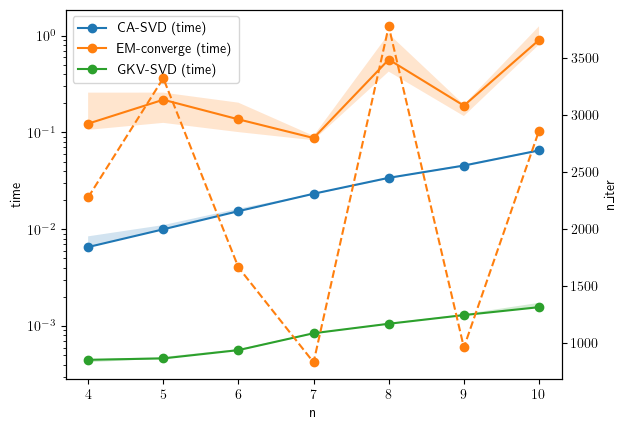

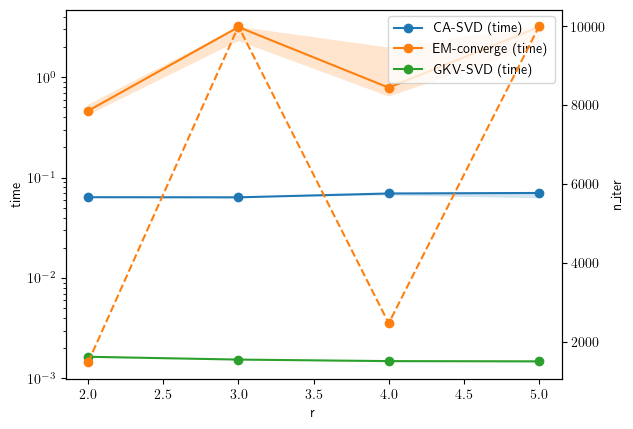

In [14]:
plt.yscale("log")
plot(df1, "n", "time")
plt.gca().set_prop_cycle(None)
plt.legend()
plt.twinx()
plot(df1, "n", "n_iter", fill=False, linestyle="--")
plt.show()

plt.yscale("log")
plot(df2, "r", "time")
plt.gca().set_prop_cycle(None)
plt.legend()
plt.twinx()
plot(df2, "r", "n_iter", fill=False, linestyle="--")
plt.show()

# Real-World Experiments

We accumulate the 3-trails in the dataset and evaluate our methods on it.

In [3]:
num_categories = 17 # {1, 2, ..., 17}
n = num_categories

all_trail_probs = np.zeros((n, n, n))
num_visited = np.zeros(num_categories)

print("reading file", end="")
with open('msnbc990928.seq', 'r') as handle:
    lines = handle.readlines()
    for line_num, line in enumerate(lines):
        #print(line)
        xs = [int(i)-1 for i in line.strip().split(" ")]
       
        for i in range(len(xs) // 3):
            x = xs[3*i:3*(i+1)]
            all_trail_probs[tuple(x)] += 1

            num_visited[x] += 1
        if line_num % 10000 == 0: print(".", end="", flush=True)
print("\n", num_visited)
print(np.min(all_trail_probs))
msnbc_distribution = Distribution.from_all_trail_probs(all_trail_probs / np.sum(all_trail_probs))

def msnbc_evaluate(row):
    _, learner, L = row
    # learned_mixture = svd_learn_new(msnbc_distribution, n, L, sample_dist=1)
    learned_mixture = learners[learner](msnbc_distribution, n, L)
    learned_distribution = Distribution.from_mixture(learned_mixture, 3)
    trail_error = msnbc_distribution.dist(learned_distribution)
    stats = {"trail_error": trail_error, "time": None}
    return stats

reading file....................................................................................

KeyboardInterrupt: 

In [3]:
num_categories = 30 # {1, 2, ..., 17}
n = num_categories

all_trail_probs = np.zeros((n, n, n))
num_visited = np.zeros(num_categories)

df = pd.read_csv('energydata_complete.csv')

# consider one column first

df = df['RH_5']
xs = pd.cut(df, bins=num_categories, labels=False)
print(xs.head)

<bound method NDFrame.head of 0        11
1        11
2        11
3        11
4        11
         ..
19730    10
19731    10
19732    10
19733    10
19734    10
Name: RH_5, Length: 19735, dtype: int64>


In [4]:
for i in range(len(xs) // 3):
    x = xs[3*i:3*(i+1)]
    all_trail_probs[tuple(x)] += 1
    num_visited[x] += 1
print(np.sum(all_trail_probs))
print(np.shape(all_trail_probs))
Rh_5_dist = Distribution.from_all_trail_probs(all_trail_probs / np.sum(all_trail_probs))

6578.0
(30, 30, 30)


In [7]:
def Rh_5_evaluate(row):
    _, learner, L = row
    # learned_mixture = svd_learn_new(msnbc_distribution, n, L, sample_dist=1)
    learned_mixture = learners[learner](Rh_5_dist, n, L)
    learned_distribution = Distribution.from_mixture(learned_mixture, 3)
    trail_error = Rh_5_dist.dist(learned_distribution)
    stats = {"trail_error": trail_error, "time": None}
    return stats

In [8]:
df = pd.DataFrame(product(range(n_trials), ["CA-SVD-EM2", "CA-SVD-EM5", "CA-SVD-EM20", "EM2", "EM5", "EM20"], np.linspace(1, 8, 8).astype(int)),
                  columns=["n_trial", "learner", "L"])
res = df.apply(Rh_5_evaluate, axis=1, result_type="expand")
df[res.columns] = res

SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
0.0
SVD LEARNER RUNNING
4.941486968930348e-21
SVD LEARNER RUNNING
1.1634904631409725e-18
SVD LEARNER RUNNING
4.9389045021807024e-17
SVD LEARNER RUNNING
4.1638202902184845e-17
SVD LEARNER RUNNING
5.425436767753892e-17
SVD LEARNER RUNNING
7.160158038793287e-17
SVD LEARNER RUNNING
6.72510123310774e-17
SVD LEAR

/Users/hayashimiyako/Desktop/DirectedStudy/WWW2023/learn.py:256: RuntimeWarning: invalid value encountered in scalar divide
  np.linalg.norm(x - y) ** 2 / (np.linalg.norm(x) * np.linalg.norm(y))


ValueError: The condensed distance matrix must contain only finite values.

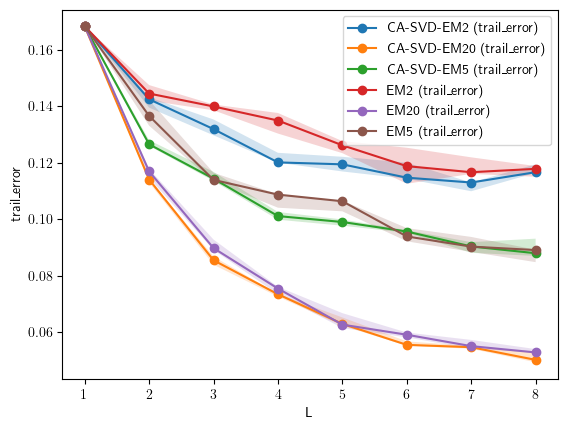

In [17]:
plot(df, "L", "trail_error")
plt.legend()
plt.show()